__Curate longitudinal dataset based on Ann-Kathrins pathology labels__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import mne
import pandas as pd
import numpy as np

from braindecode.datasets.base import BaseDataset, BaseConcatDataset

In [2]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description.csv', index_col=0)
description.shape

(33660, 18)

In [3]:
def extract_longitudinal_dataset_new(description, kind, load):
    assert kind in ['transition', 'pathological', 'non_pathological']
    dfs = []
    for s, g in description.groupby('subject'):
        if len(g) > 1:
            if g.pathological.nunique() == 2:
                if kind == 'transition':
                        dfs.append(g)
            else:
                if kind == 'pathological':
                    if g.pathological.unique() == 1:
                        dfs.append(g)
                elif kind == 'non_pathological':
                    if g.pathological.unique() == 0:
                        dfs.append(g)
    dfs = pd.concat(dfs)
    dfs = dfs.reset_index(drop=True)
    if kind == 'transition':
        assert all(dfs.groupby('subject').pathological.nunique() == 2)
    else:
        if kind in ['pathological', 'non_pathological']:
            assert all(dfs.groupby('subject').pathological.nunique() == 1)
    print("n recs", len(dfs), "n subj", dfs.subject.nunique())
    if not load:
        return dfs
    else:
        dfs = dfs.T
        ds = []
        for i, s in dfs.iteritems():
            p = s.path
            p = p.replace('/data/datasets/TUH/EEG/tuh_eeg/', '/home/jovyan/mne_data/TUH_PRE/tuh_eeg/')
            if not os.path.exists(p):
                raise RuntimeError("rec not found")
            raw = mne.io.read_raw_edf(p, preload=False, verbose='error')
            d = BaseDataset(raw, s, target_name='age')
            ds.append(d)
        ds = BaseConcatDataset(ds)
        return ds

In [4]:
df = extract_longitudinal_dataset_new(description, 'transition', False)

n recs 3357 n subj 525


In [6]:
df = extract_longitudinal_dataset_new(description, 'pathological', False)

n recs 18338 n subj 2892


In [8]:
df = extract_longitudinal_dataset_new(description, 'non_pathological', False)

n recs 4068 n subj 956


In [4]:
ds = extract_longitudinal_dataset_new(description, 'transition', True)

n recs 3357 n subj 525


In [6]:
with open('/home/jovyan/longitudinal/transition.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [7]:
ds = extract_longitudinal_dataset_new(description, 'non_pathological', True)

n recs 4068 n subj 956


In [8]:
with open('/home/jovyan/longitudinal/non_pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [9]:
ds = extract_longitudinal_dataset_new(description, 'pathological', True)

n recs 18338 n subj 2892


In [10]:
with open('/home/jovyan/longitudinal/pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

__Plot longitudinal datasets__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import torch
import numpy as np
import pandas as pd
from skorch.callbacks import Checkpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_color_codes('deep')

from braindecode.preprocessing import Preprocessor, preprocess
from braindecode import EEGRegressor
from braindecode.models import ShallowFBCSPNet

# from decode_tueg import _create_windows as create_windows

In [2]:
def plot_age_hist2(description, ax=None, hue_key=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 2))
    sns.histplot(
        data=description,
        bins=np.linspace(0,100,101,dtype=int),
        x='age',
        kde=True,
        ax=ax,
        hue=hue_key if description[hue_key].nunique() != 1 else None,
        palette=['b', 'r'] if description[hue_key].nunique() != 1 else None,
        color='r' if 0 not in description[hue_key].unique() else 'b',
    );
    return ax
    #ax.set_title(f'train (n={len(train_set.datasets)})')
    #fig.savefig('/home/jovyan/train_dist_wo_gender.jpg', bbox_inches='tight')

In [162]:
with open('/home/jovyan/longitudinal/transition.pkl', 'rb') as f:
    ds = pickle.load(f)

In [163]:
n_channels = len(ds[0][0])

Text(0, 0.5, 'Count')

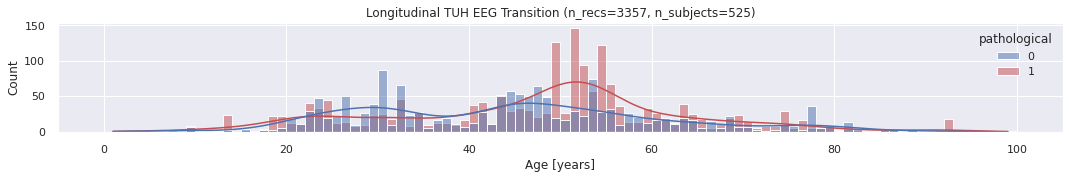

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Transition (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/transition_hist.jpg', bbox_inches='tight', dpi=300)

In [171]:
with open('/home/jovyan/longitudinal/non_pathological.pkl', 'rb') as f:
    ds = pickle.load(f)

In [172]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

Text(0, 0.5, 'Count')

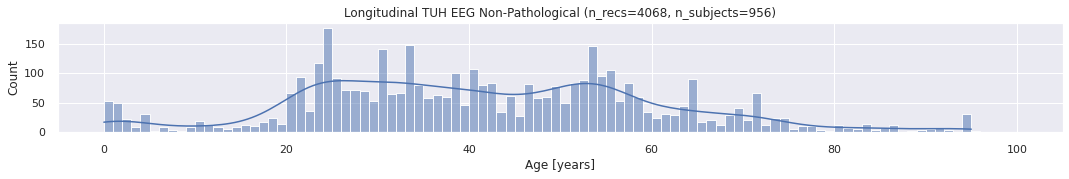

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Non-Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/non_pathological_hist.jpg', bbox_inches='tight', dpi=300)

In [183]:
with open('/home/jovyan/longitudinal/pathological.pkl', 'rb') as f:
    ds = pickle.load(f)

In [184]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

Text(0, 0.5, 'Count')

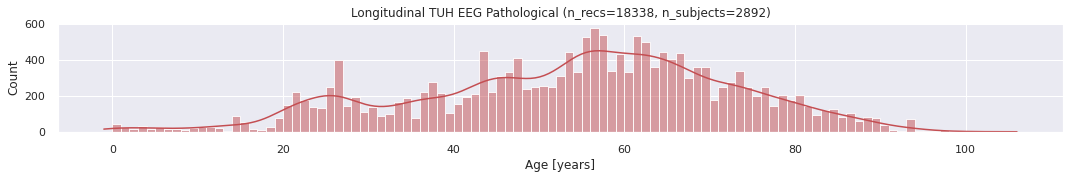

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/pathological_hist.jpg', bbox_inches='tight', dpi=300)

In [148]:
import seaborn
sns.set(color_codes=True)

In [149]:
def age_pyramid(df_of_ages_genders_and_pathology_status, train_or_eval, alpha=.5,
                fs=24, ylim=20, bins=np.linspace(0, 100, 101), out_dir=None,
              show_title=True):
    df = df_of_ages_gender_and_pathology_status
    male_df = df[df["gender"] == 0]
    female_df = df[df["gender"] == 1]

    male_abnormal_df = male_df[male_df["pathological"] == 1]
    male_normal_df = male_df[male_df["pathological"] == 0]
    female_abnormal_df = female_df[female_df["pathological"] == 1]
    female_normal_df = female_df[female_df["pathological"] == 0]

    f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=False,
                                 figsize=(15, 18))
    if show_title:
        plt.suptitle(train_or_eval+" Histogram", y=.9, fontsize=fs+5)

    ax1.hist(x=male_normal_df["age"], bins=bins, alpha=alpha, color="g",
             orientation="horizontal",
             label="Non-pathological ({:.1f}%)".format(len(male_normal_df) /
                                             len(male_df) * 100))

    ax1.hist(x=male_abnormal_df["age"], bins=bins, alpha=alpha, color="b",
             orientation="horizontal",
             label="Pathological ({:.1f}%)".format(len(male_abnormal_df) /
                                                   len(male_df) * 100))

    ax1.axhline(np.mean(male_df["age"]), color="black",
                # label="mean age {:.2f} $\pm$ {:.2f}".format(
                #     np.mean(male_df["age"]), np.std(male_df["age"])))
                label="Mean age {:.1f} ($\pm$ {:.1f})"
                .format(np.mean(male_df["age"]), np.std(male_df["age"])))
    ax1.barh(np.mean(male_df["age"]), height=2 * np.std(male_df["age"]),
             width=ylim, color="black", alpha=.25)
    ax1.set_xlim(0, ylim)

    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [2, 1, 0]
    # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

    ax1.legend(fontsize=fs, loc="lower left")
    ax1.set_title("Male ({:.1f}%)".format(100 * float(len(male_df) / len(df))),
                  fontsize=fs, loc="left", y=.95, x=.05)
    ax1.invert_xaxis()

    # second axis
    ax2.hist(x=female_normal_df["age"], bins=bins, alpha=alpha, color="y",
             orientation="horizontal",
             label="Non-pathological ({:.1f}%)".format(len(female_normal_df) /
                                             len(female_df) * 100))

    ax2.hist(x=female_abnormal_df["age"], bins=bins, alpha=alpha, color="r",
             orientation="horizontal",
             label="Pathological ({:.1f}%)".format(len(female_abnormal_df) /
                                                   len(female_df) * 100))

    ax2.axhline(np.mean(female_df["age"]), color="black", linestyle="--",
                # label="mean age {:.2f} $\pm$ {:.2f}"
                # .format(np.mean(female_df["age"]), np.std(female_df["age"])))
                label="Mean age {:.1f} ($\pm$ {:.1f})"
                .format(np.mean(female_df["age"]), np.std(female_df["age"])))
    ax2.barh(np.mean(female_df["age"]), height=2 * np.std(female_df["age"]),
             width=ylim, color="black",
             alpha=.25)
    ax2.legend(fontsize=fs, loc="lower right")
    ax2.set_xlim(0, ylim)
    # ax1.invert_yaxis()
    ax2.set_title("Female ({:.1f}%)".format(100 * len(female_df) / len(df)),
                  fontsize=fs, loc="right", y=.95, x=.95)  # , y=.005)

    plt.ylim(0, 100)
    plt.subplots_adjust(wspace=0, hspace=0)
    ax1.set_ylabel("Age [years]", fontsize=fs)
    ax1.set_xlabel("Count", fontsize=fs, x=1)
    # ax1.yaxis.set_label_coords(-.025, 0)
    plt.yticks(np.linspace(0, 100, 11), fontsize=fs - 5)
    ax1.tick_params(labelsize=fs - 5)
    ax2.tick_params(labelsize=fs - 5)
    # plt.savefig("tuh-abnormal-eeg-corpus-train-age-pyramid.pdf",
    #             bbox_inches="tight")
    if out_dir is not None:
        plt.savefig(out_dir+"tuh_{}.png".format(train_or_eval),
                    bbox_inches="tight")

In [186]:
df = ds.description[['pathological', 'age', 'gender', 'subject']]
df.genders = df.genders == 'F'

In [188]:
subject_wise = True

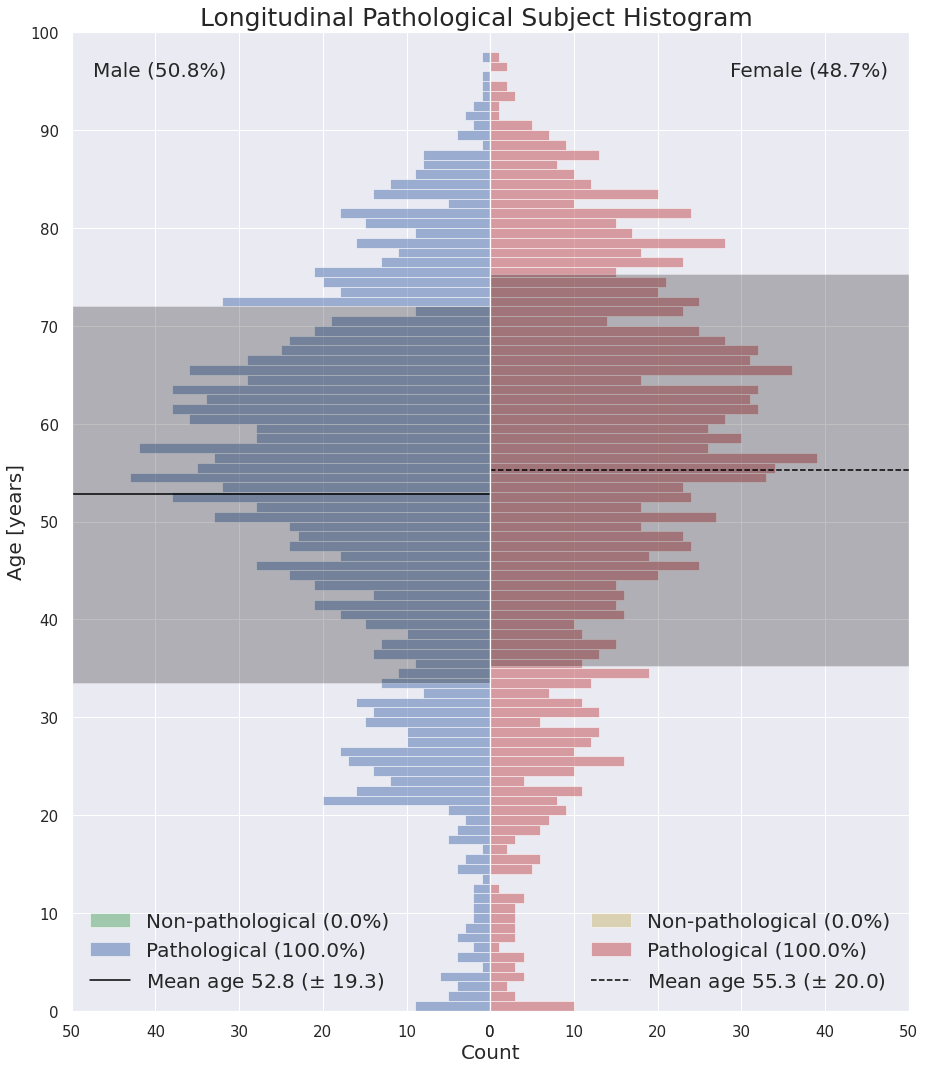

In [194]:
s = 'Recording' if not subject_wise else 'Subject'
age_pyramid(
    df.groupby(['subject', 'pathologicals'], as_index=False).mean() if subject_wise else df, 
    f'Longitudinal Pathological {s}', 
#     ylim=120 if not subject_wise else 13,
    ylim=50,
    show_title=True, fs=20,
    out_dir='/home/jovyan/', 
)